# IC50 Effect Size Prediction
This notebook aims to predict** IC50 effect size** using drug and biological feature data. I will explore the data, perform feature engineering, and compare model performances, including Random Forest, XGBoost, and Gradient Boosting.

For medical models, especially in Drug Development and Precision Medicine, it is important to be able to explain the results of ML models.

**Ensemble methods**, like those used here, are among the most powerful predictive models together with deep learning. The drawback being their interpretability. **eXplainable AI (XAI)** is the set of techniques that allow to understand, interpret and rely on the emerging results from complex AI models.

In this notebook, I have used **SHAP** to explain which variables are influencing the models most.

I also checked for **multicollinearity** (correlation between independent variables) and ran a **Principal Components Analysis (PCA)** for **Dimensionality Reduction**, and compared these results to the original models.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the dataset
data = pd.read_csv('/content/COREAD_ANOVA_Thu Oct 24 18_42_45 2024.csv')
data.head()

,Drug name,Drug ID,Drug target,Target Pathway,Feature Name,n_feature_pos,n_feature_neg,ic50_effect_size,log_ic50_mean_pos,log_ic50_mean_neg,...,feature_ic50_t_pval,feature_delta_mean_ic50,feature_pos_ic50_var,feature_neg_ic50_var,feature_pval,tissue_pval,msi_pval,fdr,Tissue Type,Screening Set
0,Camptothecin,1003,TOP1,DNA replication,AKAP9_mut,8,39,0.339283,-2.016828,-1.449832,...,0.367331,-0.566997,1.522022,1.697206,0.892995,NaN,0.017042,92.259141,COREAD,GDSC2
1,Camptothecin,1003,TOP1,DNA replication,APC_mut,34,13,0.378616,-1.372438,-2.001167,...,0.245559,0.628730,1.685005,1.591560,0.612657,NaN,0.016760,89.732053,COREAD,GDSC2
2,Camptothecin,1003,TOP1,DNA replication,ARID1A_mut,11,36,0.510071,-2.189299,-1.349883,...,0.115222,-0.839416,1.401854,1.708973,0.710600,NaN,0.016900,92.259141,COREAD,GDSC2
3,Camptothecin,1003,TOP1,DNA replication,ARID1B_mut,3,44,0.083930,-1.413952,-1.555368,...,0.910624,0.141416,1.902673,1.674104,0.521343,NaN,0.016579,85.769454,COREAD,GDSC2
4,Camptothecin,1003,TOP1,DNA replication,ARID2_mut,7,40,0.321283,-1.088645,-1.626439,...,0.364747,0.537794,1.314002,1.722600,0.152996,NaN,0.014756,76.573483,COREAD,GDSC2


## Data Overview
Let's examine the structure and contents of the dataset, including data types and null values.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Drug name                23652 non-null  object 
 1   Drug ID                  23652 non-null  int64  
 2   Drug target              20389 non-null  object 
 3   Target Pathway           23480 non-null  object 
 4   Feature Name             23652 non-null  object 
 5   n_feature_pos            23652 non-null  int64  
 6   n_feature_neg            23652 non-null  int64  
 7   ic50_effect_size         23652 non-null  float64
 8   log_ic50_mean_pos        23652 non-null  float64
 9   log_ic50_mean_neg        23652 non-null  float64
 10  log_max_conc_tested      0 non-null      float64
 11  log_max_conc_tested_2    0 non-null      float64
 12  feature_ic50_t_pval      23652 non-null  float64
 13  feature_delta_mean_ic50  23652 non-null  float64
 14  feature_pos_ic50_var  

## Exploratory Data Analysis (EDA)
### Distribution of IC50 Effect Size
To understand the distribution of our target variable, IC50 effect size, I plotted a histogram.

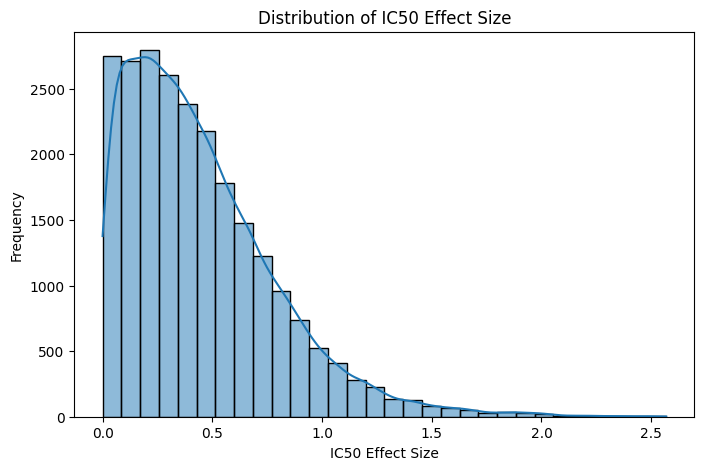

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(data['ic50_effect_size'], bins=30, kde=True)
plt.title('Distribution of IC50 Effect Size')
plt.xlabel('IC50 Effect Size')
plt.ylabel('Frequency')
plt.show()

### Feature Correlations
Examining correlations among features helps identify relationships that might influence IC50 effect size.

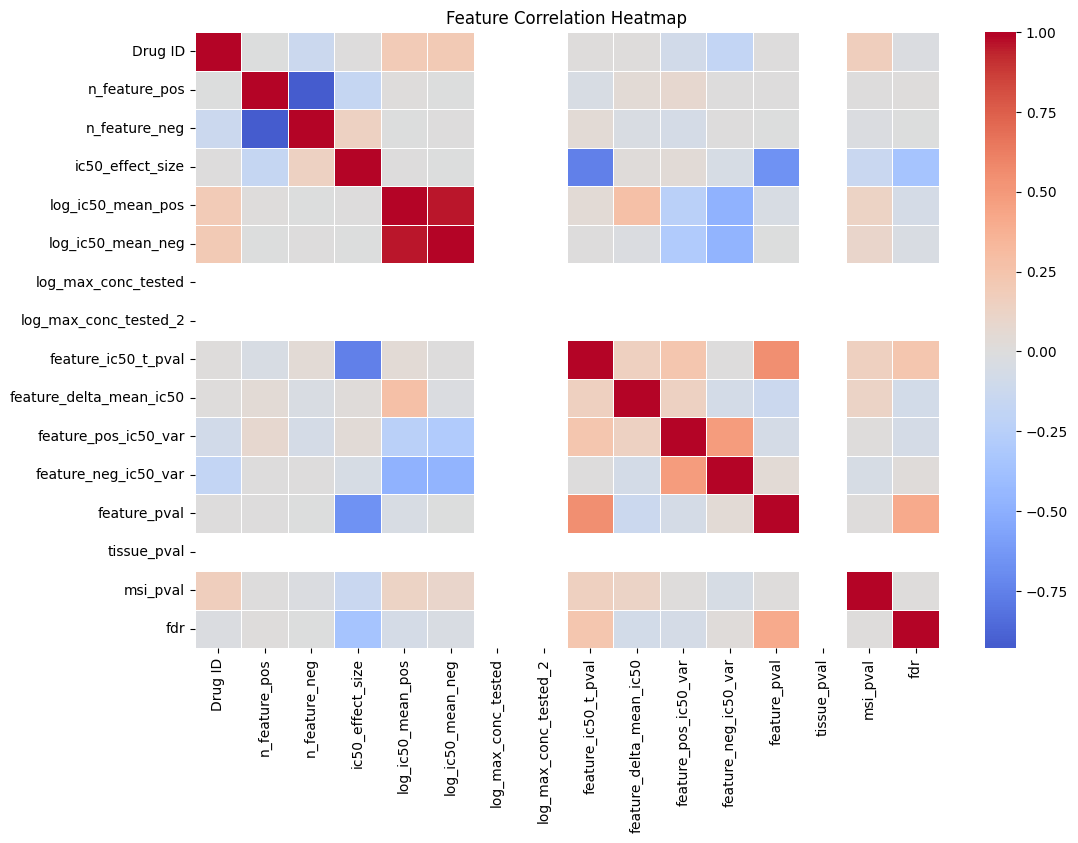

In [28]:
plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_data = data.select_dtypes(include=['number'])
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

## Data Cleaning and Preprocessing
I'll remove columns with no data and encode categorical features for modeling.

In [29]:
data_cleaned = data.drop(columns=['log_max_conc_tested', 'log_max_conc_tested_2', 'tissue_pval'])
categorical_columns = ['Drug name', 'Drug target', 'Target Pathway', 'Feature Name', 'Tissue Type', 'Screening Set']
for col in categorical_columns:
    data_cleaned[col] = LabelEncoder().fit_transform(data_cleaned[col].astype(str))

# Define features and target
X = data_cleaned.drop(columns=['ic50_effect_size'])
y = data_cleaned['ic50_effect_size']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation
### Baseline Model: Random Forest
I started with a Random Forest model as a baseline, which provides good performance and interpretability.

In [30]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest Model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf, rmse_rf

(0.017830865855815444, 0.04275689365291967)

### Feature Importance Analysis
Let's analyze the top features influencing IC50 effect size in the Random Forest model.

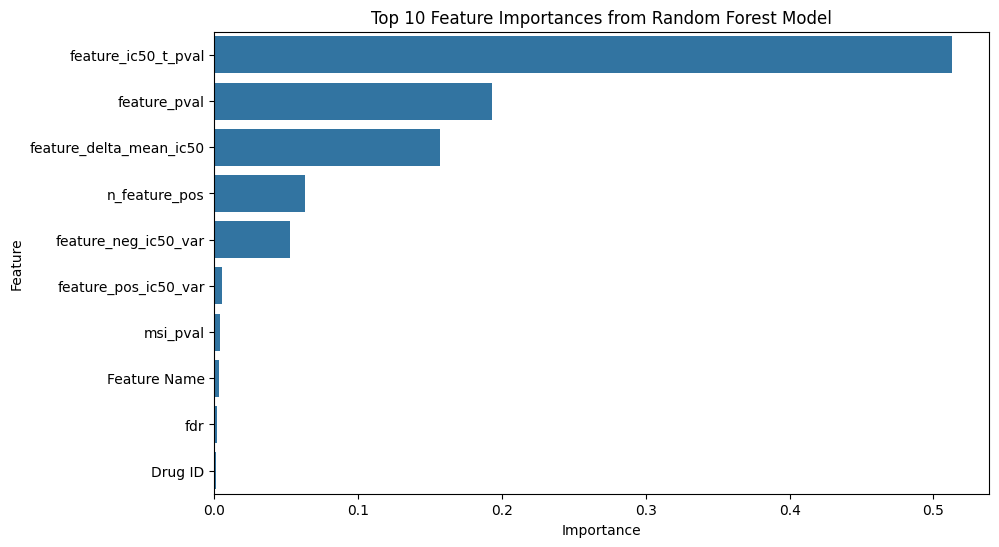

,Feature,Importance
9,feature_ic50_t_pval,0.513291
13,feature_pval,0.192798
10,feature_delta_mean_ic50,0.156641
5,n_feature_pos,0.062694
12,feature_neg_ic50_var,0.052500
11,feature_pos_ic50_var,0.005197
14,msi_pval,0.004170
4,Feature Name,0.003534
15,fdr,0.001832
1,Drug ID,0.001338


In [31]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

feature_importances.head(10)

### SHAP Analysis for Model Interpretation

To further understand the model's predictions, I used **SHAP (SHapley Additive exPlanations)**, a tool that explains the contribution of each feature to individual predictions. SHAP helps us:

1. **Identify Key Influential Features**: SHAP values quantify the importance of each feature for each individual prediction.
2. **Interpret Feature Effects**: SHAP visualizations show how specific feature values (e.g., high or low values) increase or decrease predicted IC50 effect size.




In [32]:
# Install SHAP (run this cell once if SHAP is not already installed)
#!pip install shap
import shap

In [33]:
# Use a subset of X_test for SHAP calculations
X_test_sample = X_test.sample(200, random_state=42)  # Adjust sample size as needed

# Create the explainer object using your trained Random Forest model
explainer = shap.TreeExplainer(rf_model)  # rf_model is your trained Random Forest model

# Now you can calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)

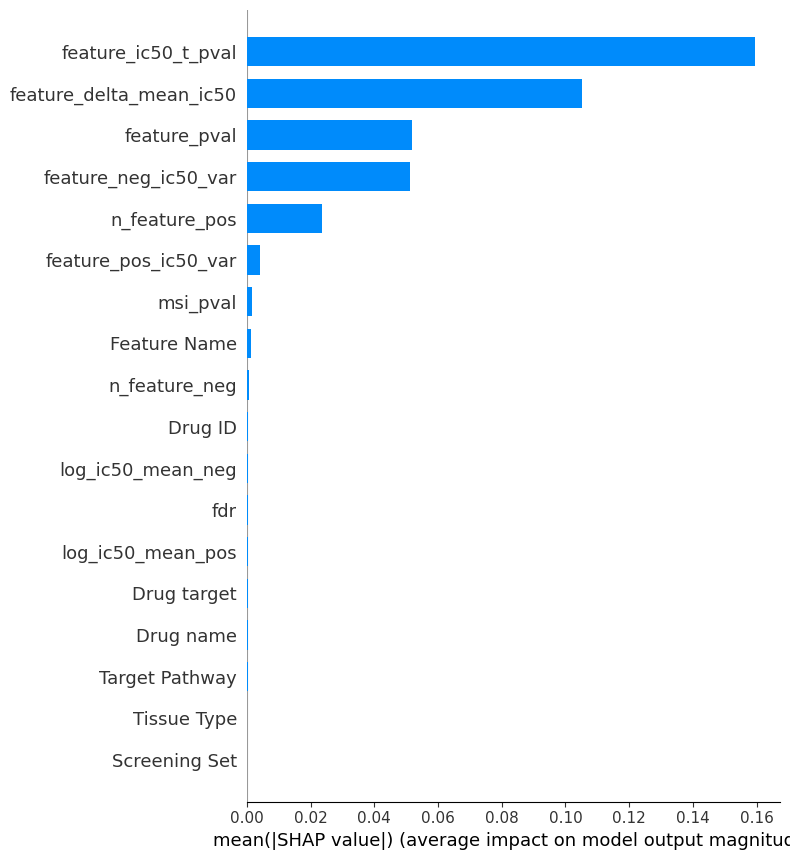

In [34]:
# Global feature importance bar plot using SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")


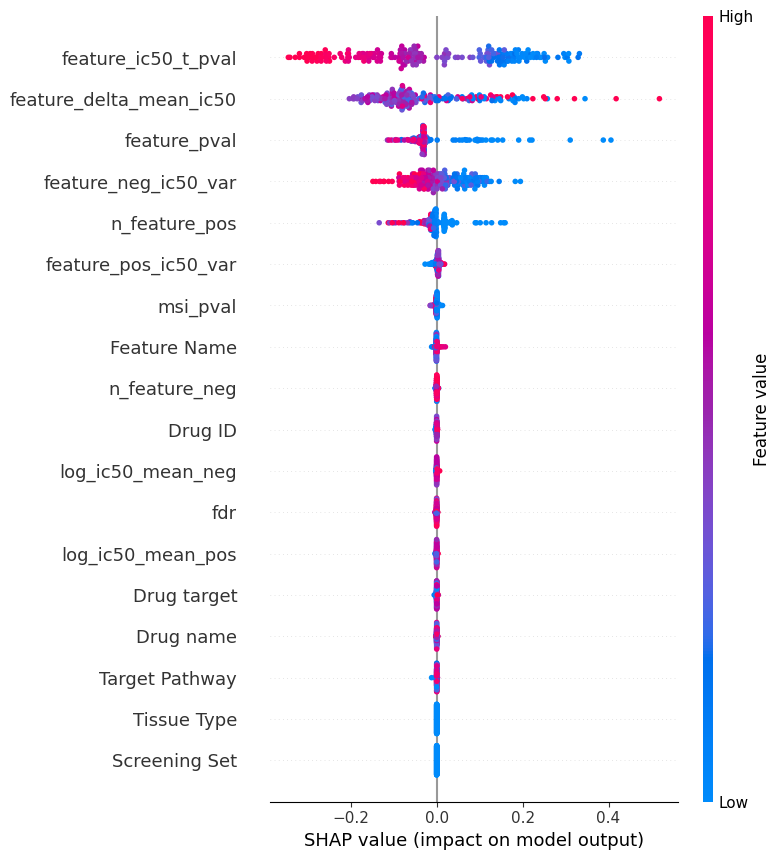

In [35]:
# Detailed SHAP summary plot for feature effects on IC50 prediction
# Use the sampled data (X_test_sample) for consistency with SHAP values
shap.summary_plot(shap_values, X_test_sample)

The plot above shows the **feature importance**. The Red dots indicate a high feature value, and blue dots show a low feature value. If red dots are mostly on the right, it suggests that higher values increase the IC50 effect size.

The SHAP value along the bottom quantifies the contribution of the feature to the prediction. A positive value means the feature increases the prediction, and a negative value decreases the prediction.

For example, for the feature: *feature_ic50_t_pval*, which is the most influential, the red dots on the left suggest higher values of this feature decrease the IC50 effect size, while the blue dots indicate that lower values increase the IC50 effect size.

### Additional Models: XGBoost and Gradient Boosting
Next, I train trained XGBoost and Gradient Boosting models and compare their performances with Random Forest.

In [36]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Initialize models with reduced complexity for training time
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=50, max_depth=2, learning_rate=0.1)
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=50, max_depth=2, learning_rate=0.1)

# Train and predict
xgb_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

# Compile Results
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'MAE': [mae_rf, mae_xgb, mae_gb],
    'RMSE': [rmse_rf, rmse_xgb, rmse_gb]
})

results

,Model,MAE,RMSE
0,Random Forest,0.017831,0.042757
1,XGBoost,0.071997,0.102854
2,Gradient Boosting,0.072472,0.104451


# Variance Inflation Factor (VIF) Analysis:

The features with the highest importance were seemingly related to the target variable. I therefore wanted to check for multicollinearity betweeen the variables.

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature in the dataset to check for multicollinearity
# Selecting only numerical features for VIF analysis
numeric_features = X.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]

# Display VIF results
vif_data


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Feature,VIF
0,Drug name,3.968309
1,Drug ID,17.501724
2,Drug target,5.804089
3,Target Pathway,6.117103
4,Feature Name,4.564616
5,n_feature_pos,4.189418
6,n_feature_neg,34.003792
7,log_ic50_mean_pos,inf
8,log_ic50_mean_neg,inf
9,feature_ic50_t_pval,5.487757


# Remove High-VIF Feature (Drug ID):

In [38]:
# Remove 'Drug ID' to reduce high multicollinearity
X_reduced = X.drop(columns=['Drug ID'])


# Apply PCA for Dimensionality Reduction:

PCA was used to reduce dimensionality to reduce multicollinearity, whilst maintaining as much variance as possible.

I first standardised the features, then set the variance threshold to 95%.

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale data before PCA, as PCA is sensitive to feature scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Verify the shape of the PCA-transformed data
X_pca.shape


(23652, 12)

# Retrain Random Forest on PCA-Transformed Data:

In [40]:
# Split PCA-transformed data into training and test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Retrain the Random Forest model
rf_model_pca = RandomForestRegressor(random_state=42)
rf_model_pca.fit(X_train_pca, y_train_pca)

# Predict and evaluate
y_pred_rf_pca = rf_model_pca.predict(X_test_pca)
mae_rf_pca = mean_absolute_error(y_test_pca, y_pred_rf_pca)
rmse_rf_pca = np.sqrt(mean_squared_error(y_test_pca, y_pred_rf_pca))

# Show results
print("MAE after PCA:", mae_rf_pca)
print("RMSE after PCA:", rmse_rf_pca)


MAE after PCA: 0.08205206495257601
RMSE after PCA: 0.11411873529839703


# Compare Original and PCA-Transformed Models:

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict and evaluate the original Random Forest model
y_pred_rf = rf_model.predict(X_test) # Assuming you have a rf_model and X_test
mae = mean_absolute_error(y_test, y_pred_rf) # Assuming you have y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Compile results for comparison
updated_results = pd.DataFrame({
    'Model': ['Random Forest (Original)', 'Random Forest (PCA)'],
    'MAE': [mae, mae_rf_pca],
    'RMSE': [rmse, rmse_rf_pca]
})

# Display updated results
updated_results

,Model,MAE,RMSE
0,Random Forest (Original),0.017831,0.042757
1,Random Forest (PCA),0.082052,0.114119


The results after the PCA were worse than the initial model, the MSE and RMSE both increased.

This suggests the original Random Forest was able to handle any multicollinearity between variables without the need for PCA or Dimensionality Reduction